# Aruco

[Aruco](https://www.uco.es/investiga/grupos/ava/portfolio/aruco/) es un módulo de OpenCV que implementa el reconocimiento de marcadores sintéticos con el que poder hacer aplicaciones de Realidad Aumentada. Su nombre proviene de **A**ugmented **R**eality **U**niversity of **Có**rdoba

En primer lugar, para poder hacer el tracking con el que anclar el mundo virtual al mundo real necesitamos un conjunto de marcadores. Dichos marcadores deben ser fáciles de detectar e identificar para que la aplicación sea lo más estable y fluida posible. Además, para que no haya duda sobre la orientación con que es detectado un marcador, es imprescindible que éste no tenga ningún eje de simetría.

Aruco permite definir marcadores personalizados aunque dispone de abundantes marcadores sintéticos preconfigurados y agrupados según sus características en lo que Aruco denomina [**diccionarios**](https://docs.opencv.org/4.x/d5/d0b/classcv_1_1aruco_1_1Dictionary.html#details). Cada diccionario asigna un número entero a cada marcador.

Trabajaremos con los diccionarios clásicos de aruco, formados por patrones de cuadros blancos y negros dispuestos en una matriz de 4x4, 5x5, 6x6 o 7x7 y rodeados por un contorno de cuadros negros.

Por ejemplo, el marcador 0 del diccionario 5x5 es el que se muestra a continuación.

![Marcador 0 del diccionario 5x5](media/5x5_1000-0.svg "Marcador 0 del diccionario 5x5")

Para reducir la tasa de errores, es decir, la detección errónea de un marcador que lleva a confundirlo con otro distinto, necesitamos maximizar la *distancia* que existe entre los marcadores del diccionario. Entendemos por distancia como el número de cuadros en que difieren entre sí dos marcadores.

Cuantos más marcadores haya en un diccionario menor será la distancia entre ellos por lo que interesa usar un diccionario con el menor número de marcadores para así maximizar la distancia entre ellos y reducir la tasa de errores. Para satisfacer las necesidades de la aplicación, para cada tamaño de marcador Aruco define 4 tamaños de diccionario con 50, 100, 250 y 1000 marcadores. Nos referiremos a cada diccionario mediante un identificador que incluye el tamaño de matriz y el número de marcadores, como por ejemplo cv2.aruco.DICT_5x5_100

Además, cada diccionario se construye agregando marcadores al los ya existentes en un diccionario de menor tamaño. Es decir, los 50 marcadores del diccionario cv2.aruco.DICT_5x5_50 son los primeros 50 marcadores de todos los diccionarios de mayor tamaño (cv2.aruco.DICT_5x5_100, cv2.aruco.DICT_5x5_250 y cv2.aruco.DICT_5x5_1000). Del mismo modo, los 250 marcadores del diccionario cv2.aruco.DICT_5x5_250 son los primeros 250 del diccionario cv2.aruco.DICT_5x5_1000.

Para obtener uno de los diccionarios preconfigurados de aruco usamos [getPredefinedDictionary](https://docs.opencv.org/4.x/de/d67/group__objdetect__aruco.html#ga68e0379bcf3799b1ff7145769f8a09c8)

In [1]:
import cv2
import numpy as np
import cuia

In [2]:
diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)

Podemos obtener la imagen de cada marcador mediante [generateImageMarker](https://docs.opencv.org/4.x/de/d67/group__objdetect__aruco.html#ga631cb40c63945cc5b9ef6b064a5f4fc2) indicando el diccionario, el número de marcador y el tamaño del marcador en píxeles. No obstante podemos recurrir al generador de marcadores [ArUco markers generator!](https://chev.me/arucogen/) donde fácilmente podremos guardar o imprimir cualquier marcador con el tamaño deseado.

Una vez seleccionado un diccionario, para la detección de marcadores debemos crear un objeto detector mediante [ArucoDetector](https://docs.opencv.org/4.x/d2/d1a/classcv_1_1aruco_1_1ArucoDetector.html) indicando el diccionario seleccionado.

In [3]:
detector = cv2.aruco.ArucoDetector(diccionario)

La detección de marcadores en una imagen se realiza mediante una llamada al método [detectMarkers](https://docs.opencv.org/4.x/d2/d1a/classcv_1_1aruco_1_1ArucoDetector.html#a0c1d14251bf1cbb06277f49cfe1c9b61) del detector.

![3 Marcadores](media/3marcadores.jpg "3 Marcadores")

In [4]:
imagen = cv2.imread("media/3marcadores.jpg")
bboxs, ids, rechazados = detector.detectMarkers(imagen)

Los valores devueltos por detectMarkers son:
* Una lista de contornos de los marcadores detectados. Cada contorno está especificado mediante una lista de los 4 vértices que lo definen empezando por el superior izquierdo.
* Una lista con los identificadores (números enteros) de los marcadores detectados
* Una lista con los contornos de candidatos a ser identificados como marcadores pero que fueron finalmente rechazados. Esto será usado solamente con fines de depurado por lo que habitualmente se desechará.

Para poder visualizar las detecciones realizadas podemos emplear [drawDetectedMarkers](https://docs.opencv.org/4.x/de/d67/group__objdetect__aruco.html#ga2ad34b0f277edebb6a132d3069ed2909)

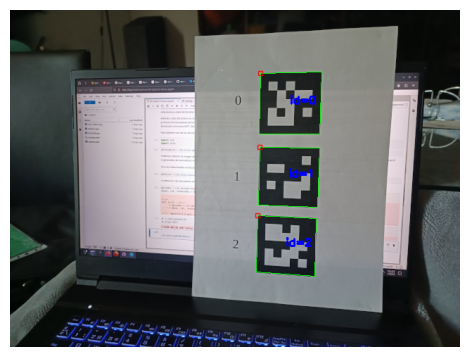

In [5]:
detectados = cv2.aruco.drawDetectedMarkers(imagen, bboxs, ids)
cuia.plot(detectados)

Podemos utilizar la clase myVideo que incluimos en cuia.py para procesar los frames de la webcam mediante la definición de una función de procesado.

In [6]:
%%capture
#Declaramos la cámara que usaremos
cam = 0
#Seleccionamos el mejor backend
bk = cuia.bestBackend(cam);

[ WARN:0@0.428] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@0.428] global cap.cpp:342 open VIDEOIO(GSTREAMER): backend is generally available but can't be used to capture by index
[ WARN:0@0.487] global cap.cpp:342 open VIDEOIO(FIREWIRE): backend is generally available but can't be used to capture by index
[ERROR:0@0.488] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
[ WARN:0@0.488] global cap.cpp:342 open VIDEOIO(OBSENSOR): backend is generally available but can't be used to capture by index


In [7]:
#Definimos un objeto de la clase myVideo para acceder a la cámara seleccionada
ar = cuia.myVideo(cam, bk)

#Definimos una función de procesado de frames para dibujar los marcadores detectados
def dibujamarcadores(frame):
    bboxs, ids, _ = detector.detectMarkers(frame)
    frame = cv2.aruco.drawDetectedMarkers(frame, bboxs, ids)
    return(frame)

#Asignamos dicha función al objeto ar
ar.process = dibujamarcadores
#Reproducimos el video hasta que se pulse la tecla espacio
ar.play("AR", key=ord(' '))
#Finalmente liberamos los recursos
ar.release()

El objetivo del uso de marcadores es obtener un punto de referencia común entre mundo real y mundo virtual de modo que se puedan ubicar elementos virtuales en el mundo real usando coordenadas del mundo real (especificadas en metros). La homografía es la función matemática que calcula la trasformación sufrida por un marcador conocido para ser visto tal y como es percibido por la cámara.

Supongamos que tenemos el marcador 0 del diccionario 5x5 impreso a un tamaño de 19cm de lado.

![Marcador 0 del diccionario 5x5](media/5x5_1000-0.svg "Marcador 0 del diccionario 5x5")

Y que dicho marcador es captado por la cámara

![Marcador 0 del diccionario 5x5](media/marcador0.png "Marcador 0 del diccionario 5x5")

La homografía que indica la transformación se calcula mediante [estimatePoseSingleMarkers](https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#gaba7f1e107f93451e2bc43b8ea96eef8c) que devuelve:
* rvecs: Son los vectores de rotación (en radianes) de cada uno de los marcadores detectados
* tvecs: Son los vectores de traslación (en metros) de cada marcador detectado
* objPoints: Coordenadas (en metros) de los vértices de cada marcador (empleado principalmente para depuración

Para poder calcular la homiografía es necesario indicar los parámetros de calibración de la cámara (que previamente habíamos guardado en camara.py) y el tamaño (en metros) del lado de cada marcador.

In [8]:
import camara
imagen = cv2.imread("media/marcador0.png")
bboxs, ids, rechazados = detector.detectMarkers(imagen)
rvecs, tvecs, objPoints = cv2.aruco.estimatePoseSingleMarkers(bboxs, 0.19, camara.cameraMatrix, camara.distCoeffs) 
print("Vectores de rotación (radianes): ", rvecs)
print("Vectores de traslación (metros): ", tvecs)
print("objPoints: ", objPoints)

Vectores de rotación (radianes):  [[[-1.72124997  2.0328853  -0.30515129]]]
Vectores de traslación (metros):  [[[ 0.13913544 -0.0235013   0.39442688]]]
objPoints:  [[[-0.095  0.095  0.   ]]

 [[ 0.095  0.095  0.   ]]

 [[ 0.095 -0.095  0.   ]]

 [[-0.095 -0.095  0.   ]]]


Emplearemos la función [drawFrameAxes](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gab3ab7bb2bdfe7d5d9745bb92d13f9564) para mostrar los ejes de coordenadas definidas por los marcadores detectados. El eje X se representa en rojo, el Y en verde y el Z en azul.

In [9]:
ar = cuia.myVideo(cam, bk)

def dibujaejes(frame):
    tam = 0.19 #Tamaño (en metros) del lado del marcador
    bboxs, ids, _ = detector.detectMarkers(frame)
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(bboxs, tam, camara.cameraMatrix, camara.distCoeffs) 
    if rvecs is not None:
        for i in range(len(rvecs)):
            frame = cv2.drawFrameAxes(frame, camara.cameraMatrix, camara.distCoeffs, rvecs[i], tvecs[i], length=0.1, thickness=2)
    return(frame)

ar.process = dibujaejes
ar.play("Ejes", key=ord(' '))
ar.release()

Cada marcador detectado define un origen de coordenadas ubicado en su centro. 

Para culminar el proceso de mezclar mundo real y mundo virtual necesitamos un modo de conocer dónde se proyectan en la pantalla los puntos definidos en el mundo real respecto del marcador. Eso se realiza mediante la función [projectPoints](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1019495a2c8d1743ed5cc23fa0daff8c) que recibe los puntos a proyectar (especificados en metros respecto al marcador) y devuelve la posición en pantalla (especificada en fila y columna).

Por ejemplo para colocar un punto en el centro del marcador proyectamos el punto (0, 0, 0) del mundo real para conocer las coordenadas de pantalla en las que hay que dibujer el punto.

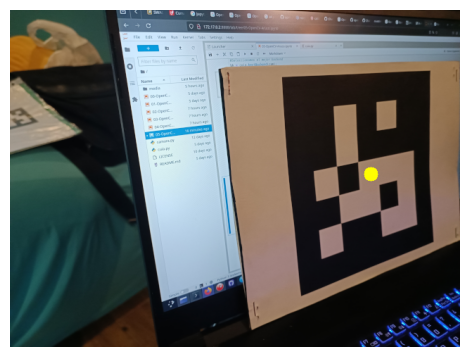

In [10]:
imagen = cv2.imread("media/marcador0.png")
bboxs, ids, rechazados = detector.detectMarkers(imagen)
rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(bboxs, 0.19, camara.cameraMatrix, camara.distCoeffs) 
p, _ = cv2.projectPoints(np.array([[0.0,0.0,0.0]]), rvecs[0], tvecs[0], camara.cameraMatrix, camara.distCoeffs)
resultado = cv2.circle(imagen, p[0][0].astype(int), 10, (0,255,255), -1)
cuia.plot(resultado)

El resultado de projectPoints es un vector de vectores de proyecciones de puntos ya que se puede usar para proyectar un vector de puntos. Además el resultado está expresado en coordenadas reales por lo que si queremos conocer el pixel debemos transformar dichas coordenadas a valores enteros. Para simplificar el proceso definiré una función de proyección.

In [11]:
def proyeccion(puntos, rvec, tvec, cameraMatrix, distCoeffs):
    if isinstance(puntos, list):
        return(proyeccion(np.array(puntos, dtype=np.float32), rvec, tvec, cameraMatrix, distCoeffs))
    if isinstance(puntos, np.ndarray):
        if puntos.ndim == 1 and puntos.size == 3:
            res, _ = cv2.projectPoints(puntos.astype(np.float32), rvec, tvec, cameraMatrix, distCoeffs)
            return(res[0][0].astype(int))
        if puntos.ndim > 1:
            aux = proyeccion(puntos[0], rvec, tvec, cameraMatrix, distCoeffs)
            aux = np.expand_dims(aux, axis=0)
            for p in puntos[1:]:
                aux = np.append(aux, [proyeccion(p, rvec, tvec, cameraMatrix, distCoeffs)], axis=0)
            return(np.array(aux))

Dibujemos una pirámide desde las esquinas del marcador hasta una cúspide ubicada a 15cm de altura. Como el centro del marcador tiene las coordenadas (0,0,0), si el marcador tiene un tamaño T entonces los vértices de la base serán (-T/2, -T/2, 0), (T/2, -T/2, 0), (T/2, T/2, 0) y (-T/2, T/2, 0). La cúspide estará en (0, 0, 0.15)

In [12]:
ar = cuia.myVideo(cam, bk)

def piramide(frame):
    T = 0.19 #Tamaño (en metros) del lado del marcador
    color = (0, 255, 255) #Color amarillo
    grosor = 2
    bboxs, ids, _ = detector.detectMarkers(frame)
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(bboxs, T, camara.cameraMatrix, camara.distCoeffs) 
    if rvecs is not None:
        for i in range(len(rvecs)):
            a = [[0,0,0.15],
                 [-T/2,-T/2,0],
                 [T/2,-T/2,0],
                 [T/2,T/2,0],
                 [-T/2,T/2,0]]
            p = proyeccion(a, rvecs[i], tvecs[i], camara.cameraMatrix, camara.distCoeffs)
            frame = cv2.line(frame, p[1], p[2], color, grosor)
            frame = cv2.line(frame, p[2], p[3], color, grosor)
            frame = cv2.line(frame, p[3], p[4], color, grosor)
            frame = cv2.line(frame, p[4], p[1], color, grosor)
            frame = cv2.line(frame, p[1], p[0], color, grosor)
            frame = cv2.line(frame, p[2], p[0], color, grosor)
            frame = cv2.line(frame, p[3], p[0], color, grosor)
            frame = cv2.line(frame, p[4], p[0], color, grosor)
    return(frame)

ar.process = piramide
ar.play("Pirámide", key=ord(' '))
ar.release()

Como el vector de traslación está expresdo en metros podemos usarlo para estimar la distancia del marcador a la cámara mediante el cálculo del módulo del vector. Una de las funciones incluidas en numpy es [linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm) que podemos usar para calcular el módulo (norma de orden 2)

In [13]:
ar = cuia.myVideo(cam, bk)

def calculadistancia(frame):
    tam = 0.19 #Tamaño (en metros) del lado del marcador
    bboxs, ids, _ = detector.detectMarkers(frame)
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(bboxs, tam, camara.cameraMatrix, camara.distCoeffs) 
    if rvecs is not None:
        for i in range(len(rvecs)):
            distancia = int(100*np.linalg.norm(np.array(tvecs[i]), ord=2))
            origen = proyeccion([0,0,0], rvecs[i], tvecs[i], camara.cameraMatrix, camara.distCoeffs)
            frame = cv2.putText(frame, str(distancia)+"cm", origen, 0, 1, (0,255,255), 2)
    return(frame)

ar.process = calculadistancia
ar.play("Distancia", key=ord(' '))
ar.release()

Ya tenemos todas las herramientas necesarias para construir la realidad aumentada. Tan solo necesitamos indicar la tarea que se debe realizar en función del marcador detectado.

Por ejemplo podemos mostrar una imagen diferente en función del marcador.

In [16]:
baboon = cv2.imread("media/baboon.jpg")
apple = cv2.imread("media/apple.jpg")
chicky = cv2.imread("media/chicky_512.png")

imagenes = [baboon, apple, chicky]

ar = cuia.myVideo(cam, bk)

def variasimagenes(frame):
    hframe, wframe, _ = frame.shape
    tam = 0.1 #Tamaño (en metros) del lado del marcador
    bboxs, ids, _ = detector.detectMarkers(frame)
    rvecs, tvecs, objPoints = cv2.aruco.estimatePoseSingleMarkers(bboxs, tam, camara.cameraMatrix, camara.distCoeffs) 
    if rvecs is not None:
        for i in range(len(rvecs)):
            imagen = cv2.cvtColor(imagenes[ids[i][0]], cv2.COLOR_BGR2BGRA)
            h, w, _ = imagen.shape
            origen = np.array([[0,0],[w,0],[w,h],[0,h]])
            destino = proyeccion(objPoints, rvecs[i], tvecs[i], camara.cameraMatrix, camara.distCoeffs)
            M = cv2.getPerspectiveTransform(np.float32(origen), np.float32(destino))
            warp = cv2.warpPerspective(imagen, M, dsize=(wframe,hframe), borderMode=cv2.BORDER_TRANSPARENT)
            res = cuia.alphaBlending(warp, frame)
            return(res)
    else:
        res = frame
    return(res)

ar.process = variasimagenes
ar.play("Varias imágenes", key=ord(' '))
ar.release()

In [15]:
imagen = cv2.imread("media/opencv.png", cv2.IMREAD_UNCHANGED)

ar = cuia.myVideo(cam, bk)

def variasimagenes(frame):
    h,w,_ = imagen.shape
    frame = cuia.alphaBlending(imagen, frame)
    return(frame)

ar.process = variasimagenes
ar.play("Varias imágenes", key=ord(' '))
ar.release()